# Uncovering Stock Market Trends: A Statistical Exploration and Predictive Analysis

COMPSCI 216: Everything Data

Group Members (listed in the alphabetic order of the last name):
- Xin Jiang (xj56)
- Yunheng Wang (yw568)
- Ziyue Yin (zy166)
- Yitong Zhou (yz814)

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats

Step 1: Import the Dow Jones Index Data

In [2]:
# Download 3 years of daily data for the Dow Jones Index
symbol = '^DJI'  # Ticker symbol for Dow Jones Industrial Average
# symbol = '^GSPC'  # Ticker symbol for S&P 500
# symbol = 'AAPL'  # Ticker symbol for Apple Inc.
data = yf.download(symbol, start='2021-01-01', end='2024-12-01')

[*********************100%***********************]  1 of 1 completed


Step 2: Data Cleaning

In [3]:
# Check for missing values and handle them appropriately
data.dropna(inplace=True)

Step 3: Calculate Daily Returns

Price          Adj Close         Close          High           Low  \
Ticker              ^DJI          ^DJI          ^DJI          ^DJI   
Date                                                                 
2021-01-05  30391.599609  30391.599609  30504.890625  30141.779297   
2021-01-06  30829.400391  30829.400391  31022.650391  30313.070312   
2021-01-07  31041.130859  31041.130859  31193.400391  30897.859375   
2021-01-08  31097.970703  31097.970703  31140.669922  30793.269531   
2021-01-11  31008.689453  31008.689453  31096.980469  30832.060547   

Price               Open     Volume Log_Return  
Ticker              ^DJI       ^DJI             
Date                                            
2021-01-05  30204.250000  350910000   0.005534  
2021-01-06  30362.779297  500430000   0.014303  
2021-01-07  30901.179688  427810000   0.006844  
2021-01-08  31069.580078  381150000   0.001829  
2021-01-11  31015.369141  356540000  -0.002875  


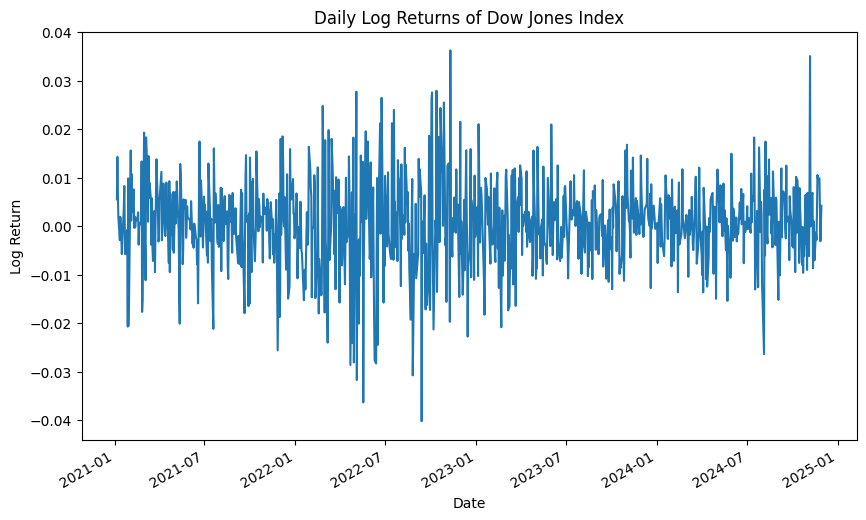

In [4]:
# Calculate daily returns and transform them to log returns
data['Log_Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Drop NaN values resulting from shift operation
data.dropna(inplace=True)

# Display the first few rows of the cleaned data with daily returns
print(data.head())

# Plotting the log returns
data['Log_Return'].plot(figsize=(10, 6))
plt.title('Daily Log Returns of Dow Jones Index')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

Descriptive Statistics for Log Returns:
count    983.000000
mean       0.000403
std        0.008960
min       -0.040215
25%       -0.004400
50%        0.000661
75%        0.005600
max        0.036285
dtype: float64
Skewness: -0.20614103785104634
Kurtosis: 1.7245779738550775
Shapiro-Wilk Test for Normality:
Statistic=0.9805798232582288, P-value=3.6062236093192216e-10


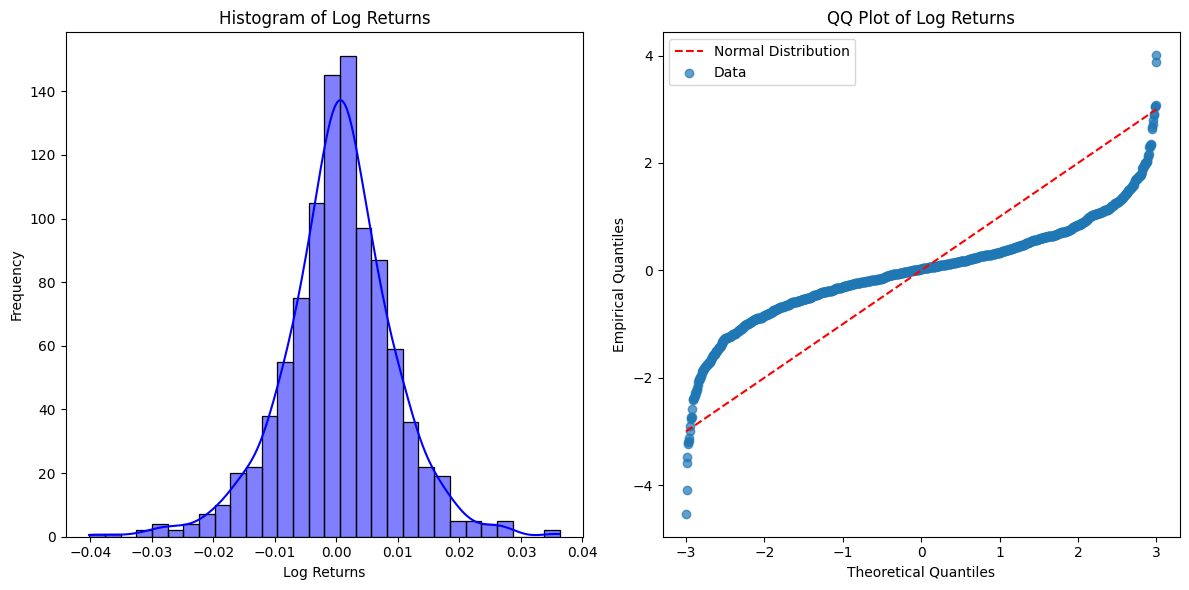

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, norm

# Assume `log_returns` contains the log returns of Dow Jones index
log_returns = data['Log_Return'].values
log_returns_series = pd.Series(log_returns)

# Basic statistics
print("Descriptive Statistics for Log Returns:")
print(log_returns_series.describe())

# Check for skewness and kurtosis
skewness = log_returns_series.skew()
kurtosis = log_returns_series.kurtosis()
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

# Test for normality
stat, p_value = shapiro(log_returns)
print(f"Shapiro-Wilk Test for Normality:\nStatistic={stat}, P-value={p_value}")

# Visualization
plt.figure(figsize=(12, 6))

# Plot histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(log_returns, kde=True, bins=30, color='blue')
plt.title("Histogram of Log Returns")
plt.xlabel("Log Returns")
plt.ylabel("Frequency")

# QQ plot for normality check
plt.subplot(1, 2, 2)
norm_theoretical = np.linspace(-3, 3, len(log_returns))
norm_actual = np.sort((log_returns - log_returns.mean()) / log_returns.std())
plt.plot(norm_theoretical, norm_theoretical, color="red", linestyle="--", label="Normal Distribution")
plt.scatter(norm_theoretical, norm_actual, alpha=0.7, label="Data")
plt.title("QQ Plot of Log Returns")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Empirical Quantiles")
plt.legend()

plt.tight_layout()
plt.show()

Step 4: Gibbs Sampling for Parameter Estimation

In [7]:
import numpy as np
from scipy.stats import invgamma, norm

# Hyperparameters for priors
mu_prior_mean = 0        # Mean for mu prior
mu_prior_variance = 1000 # Variance for mu prior

alpha_prior = 0.1  # Shape parameter for InverseGamma (sigma2 prior)
beta_prior = 0.1   # Scale parameter for InverseGamma (sigma2 prior)

# Gibbs sampling parameters
num_samples = 1000  # Total number of samples
burn_in = 100       # Number of burn-in samples to discard

# Initialize variables
mu_samples = []
sigma2_samples = []

# Initial values
current_mu = 0
current_sigma2 = 1

# Replace 'data' and 'Log_Return' with your DataFrame/column names as needed
log_returns = data['Log_Return'].values

for _ in range(num_samples):
    # Sample mu from the conditional posterior
    mu_posterior_variance = 1.0 / (len(log_returns) / current_sigma2 + 1.0 / mu_prior_variance)
    mu_posterior_mean = mu_posterior_variance * (
        np.sum(log_returns) / current_sigma2 + mu_prior_mean / mu_prior_variance
    )
    current_mu = norm.rvs(mu_posterior_mean, np.sqrt(mu_posterior_variance))
    mu_samples.append(current_mu)

    # Sample sigma2 from the conditional posterior
    alpha_post = alpha_prior + len(log_returns) / 2.0
    beta_post = beta_prior + np.sum((log_returns - current_mu) ** 2) / 2.0
    current_sigma2 = invgamma.rvs(alpha_post, scale=beta_post)
    sigma2_samples.append(current_sigma2)

# Discard burn-in samples
mu_samples_burned = mu_samples[burn_in:]
sigma2_samples_burned = sigma2_samples[burn_in:]

# Estimated parameters after burn-in
estimated_mu = np.mean(mu_samples_burned)
estimated_sigma2 = np.mean(sigma2_samples_burned)

print(f"Estimated Mean (mu) after burn-in: {estimated_mu}")
print(f"Estimated Variance (sigma^2) after burn-in: {estimated_sigma2}")

# 95% credible intervals (based on posterior samples after burn-in)
mu_ci = np.percentile(mu_samples_burned, [2.5, 97.5])
sigma2_ci = np.percentile(sigma2_samples_burned, [2.5, 97.5])

print(f"95% Credible Interval for mu: {mu_ci}")
print(f"95% Credible Interval for sigma^2: {sigma2_ci}")


Estimated Mean (mu) after burn-in: 0.000392302508869177
Estimated Variance (sigma^2) after burn-in: 0.00028450174485132774
95% Credible Interval for mu: [-0.00069087  0.00154701]
95% Credible Interval for sigma^2: [0.00026023 0.00031209]


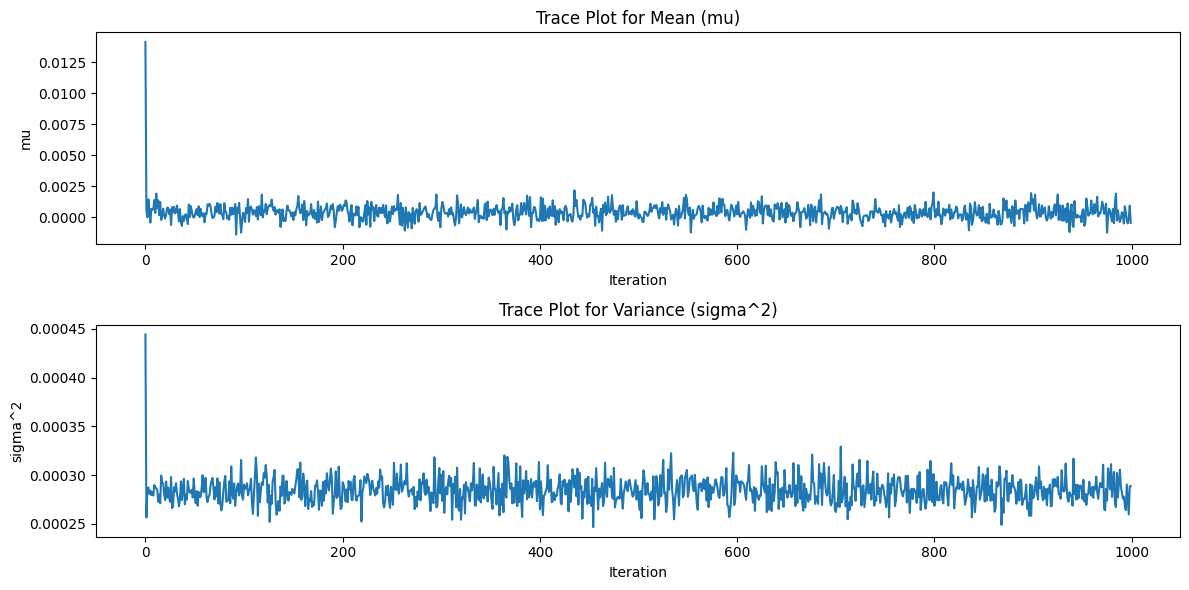

Estimated Mean (mu): 0.00040483904329239326
Estimated Variance (sigma^2): 0.0002844616874944344


In [8]:
# Convergence Diagnostics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotting mu samples
plt.subplot(2, 1, 1)
plt.plot(mu_samples)
plt.title('Trace Plot for Mean (mu)')
plt.xlabel('Iteration')
plt.ylabel('mu')

# Plotting sigma2 samples
plt.subplot(2, 1, 2)
plt.plot(sigma2_samples)
plt.title('Trace Plot for Variance (sigma^2)')
plt.xlabel('Iteration')
plt.ylabel('sigma^2')

plt.tight_layout()
plt.show()

# Summary Statistics
estimated_mu = np.mean(mu_samples)
estimated_sigma2 = np.mean(sigma2_samples)
print(f'Estimated Mean (mu): {estimated_mu}')
print(f'Estimated Variance (sigma^2): {estimated_sigma2}')


<Figure size 800x400 with 0 Axes>

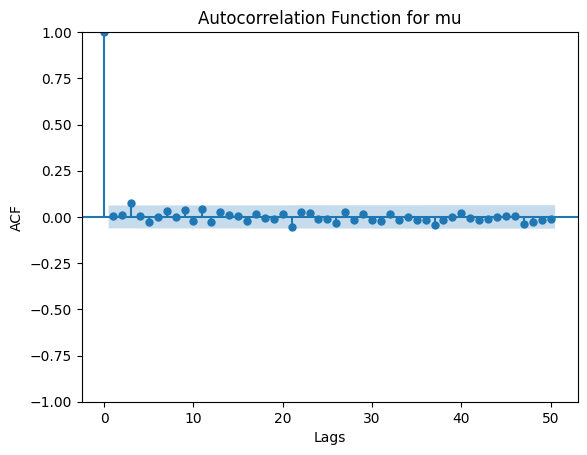

<Figure size 800x400 with 0 Axes>

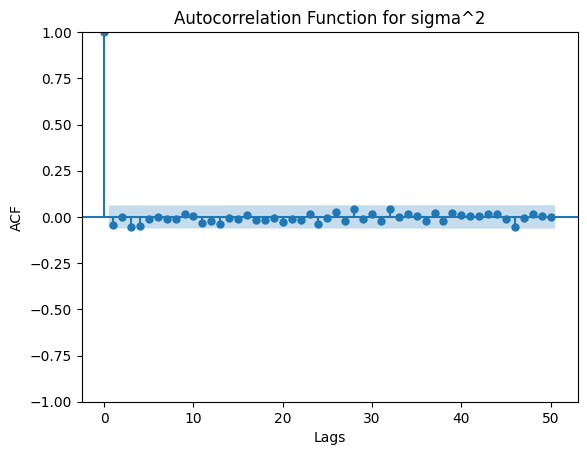

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Function to plot ACF for a given parameter
def plot_autocorrelation(samples, param_name):
    plt.figure(figsize=(8, 4))
    plot_acf(samples, lags=50, alpha=0.05)
    plt.title(f"Autocorrelation Function for {param_name}")
    plt.xlabel("Lags")
    plt.ylabel("ACF")
    plt.show()

# Plot ACF for mu and sigma^2
plot_autocorrelation(mu_samples, "mu")
plot_autocorrelation(sigma2_samples, "sigma^2")

In [10]:
# Step 5: 计算每组 Gibbs 样本的 VaR 和 ES
# Define 0.99 confidence interval z-score
confidence_level = 0.99
z_score = stats.norm.ppf(1 - confidence_level)

# Compute VaR and ES for each sample
VaR_samples = []
ES_samples = []

for mu, sigma2 in zip(mu_samples, sigma2_samples):
    VaR = mu + z_score * np.sqrt(sigma2)
    ES = mu - (stats.norm.pdf(z_score) / (1 - confidence_level)) * np.sqrt(sigma2)
    VaR_samples.append(VaR)
    ES_samples.append(ES)

# Convert to numpy arrays for analysis
VaR_samples = np.array(VaR_samples)
ES_samples = np.array(ES_samples)

# Print summary statistics
print(f"VaR (99% CI): Mean={VaR_samples.mean():.5f}, StdDev={VaR_samples.std():.5f}")
print(f"ES (99% CI): Mean={ES_samples.mean():.5f}, StdDev={ES_samples.std():.5f}")
# 95%

VaR (99% CI): Mean=-0.03882, StdDev=0.00104
ES (99% CI): Mean=-0.04453, StdDev=0.00114


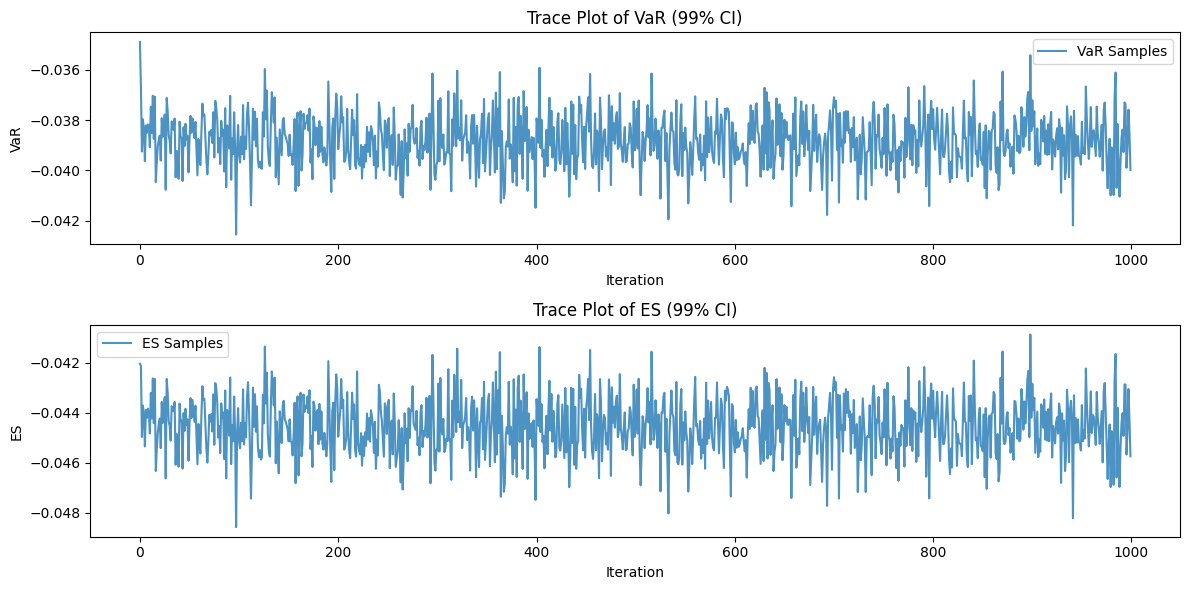

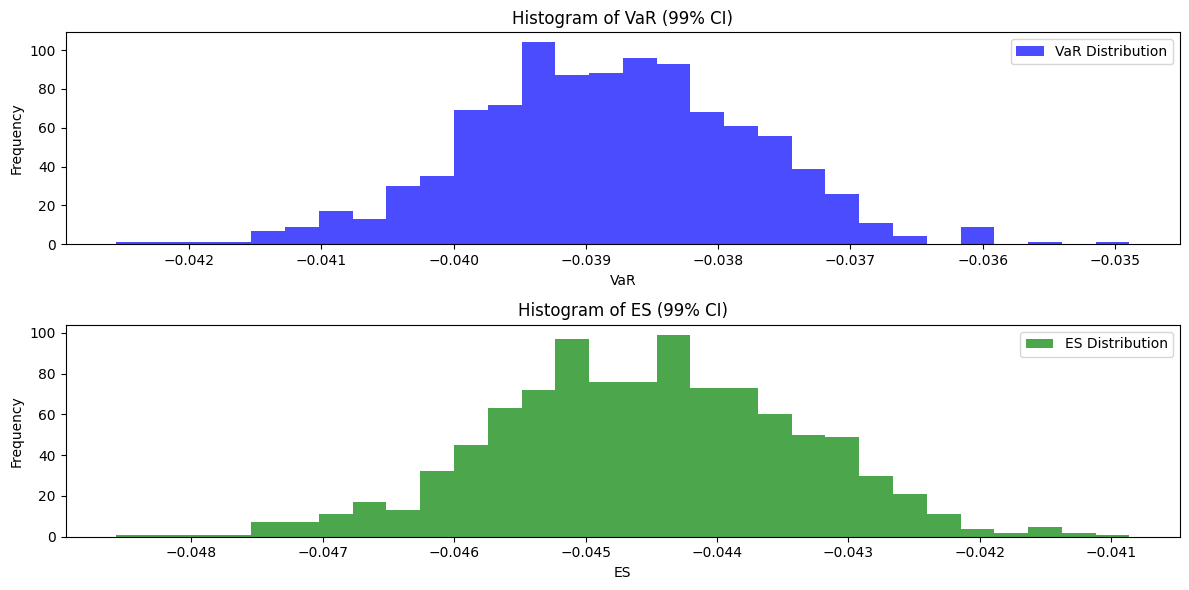

In [11]:
import matplotlib.pyplot as plt

# Trace plots
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(VaR_samples, label='VaR Samples', alpha=0.8)
plt.title("Trace Plot of VaR (99% CI)")
plt.xlabel("Iteration")
plt.ylabel("VaR")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ES_samples, label='ES Samples', alpha=0.8)
plt.title("Trace Plot of ES (99% CI)")
plt.xlabel("Iteration")
plt.ylabel("ES")
plt.legend()

plt.tight_layout()
plt.show()

# Histograms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.hist(VaR_samples, bins=30, alpha=0.7, label='VaR Distribution', color='blue')
plt.title("Histogram of VaR (99% CI)")
plt.xlabel("VaR")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(ES_samples, bins=30, alpha=0.7, label='ES Distribution', color='green')
plt.title("Histogram of ES (99% CI)")
plt.xlabel("ES")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()